In [1]:
import os
import sys
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import uproot 
import time
from training_func import*
from matplotlib.colors import LogNorm


In [2]:
NEvent = 10000
n_epochs = 200
NAME = "_SupRes_NuTot"
PATH_NN='model_NN'+str(NAME)+'.pt'


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch import tensor
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [4]:
true_pix, orig_pix, det_size = 128, 64, 125.
LayerPix = np.array([64, 16])
supL=np.array([64, 64])
No_Lay=np.array([13,34])

In [5]:
train_Layer=np.load("numpy_fil/train_Layer.npy")
val_Layer=np.load("numpy_fil/val_Layer.npy")
train_ch=np.load("numpy_fil/train_ch.npy")
train_nu=np.load("numpy_fil/train_nu.npy")
val_ch=np.load("numpy_fil/val_ch.npy")
val_nu=np.load("numpy_fil/val_nu.npy")


In [6]:
print("NEvent - ",val_Layer.shape[0]+train_Layer.shape[0])

NEvent -  10000


[64 16]


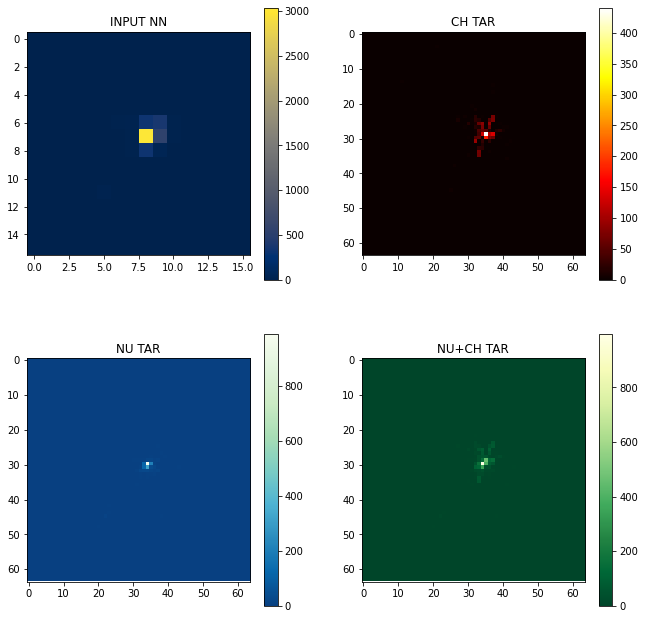

In [7]:
ev, l = 23, 1
print(LayerPix)
plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title("INPUT NN")
plt.imshow(val_Layer[ev][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(222)
plt.title("CH TAR")
plt.imshow(val_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(223)
plt.title("NU TAR")
plt.imshow(val_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(224)
plt.title("NU+CH TAR")
plt.imshow(val_nu[ev][l].T+val_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.show()

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [9]:
cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )


In [10]:
torch.cuda.get_device_name( torch.cuda.current_device() )



'Quadro P2000'

In [11]:
###############

#CNN 

##############

class Upconv(nn.Module):
    def __init__(self, upscale_factor):
        super(Upconv, self).__init__()

        self.prelu = nn.LeakyReLU(negative_slope=0.1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=1,padding=1) 
        self.conv4 = nn.Conv2d(64, 128,kernel_size=3,stride=1,padding=1) 
        self.conv5 = nn.Conv2d(128, 128,kernel_size=3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(128, 256,kernel_size=3,stride=1,padding=1)
        #self.conv7 = nn.ConvTranspose2d(256, 1,kernel_size=4,stride=2,padding=1,bias=False)
        self.conv8 = nn.PixelShuffle(upscale_factor)
        self.convf = nn.Conv2d( int(256/upscale_factor**2), 1,kernel_size=1)

    def forward(self, x):
        x = self.bn1(self.prelu(self.conv1(x)))
        x = self.bn2(self.prelu(self.conv2(x)))
        x = self.bn3(self.prelu(self.conv3(x)))
        x = self.bn4(self.prelu(self.conv4(x)))
        x = self.bn5(self.prelu(self.conv5(x)))
        x = self.bn6(self.prelu(self.conv6(x)))
        x = self.conv8(x)
        x = self.convf(x)
        x = self.relu(x)
        
        
        return x

In [16]:
class SuperResModel(nn.Module):
    
    def __init__(self):
        super(SuperResModel, self).__init__()
        self.cnn1 = Upconv(upscale_factor = int(orig_pix/LayerPix[0]) ).float()
        self.cnn2 = Upconv(upscale_factor = int(orig_pix/LayerPix[1]) ).float()


        self.cnn_comb = nn.Conv2d(3, 4,kernel_size=1,stride=1,padding=0)
        
        #self.cnn1_out_ch = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        #self.cnn2_out_ch = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)
         
        self.cnn1_out_nu = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        self.cnn2_out_nu = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)
        
        self.cnn1_out_tot = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[0]),stride=int(orig_pix/supL[0]),padding=0)
        self.cnn2_out_tot = nn.Conv2d(1, 1,kernel_size=int(orig_pix/supL[1]),stride=int(orig_pix/supL[1]),padding=0)

    def forward(self, x):
        

        out1 = self.cnn1( x[:,0:1, 0:LayerPix[0], 0:LayerPix[0]].float() )
        out2 = self.cnn2( x[:,1:2, 0:LayerPix[1], 0:LayerPix[1]].float() )
        out3 = x[:, 2:3, 0:orig_pix, 0:orig_pix].float()
        
        merged_im = torch.cat(  (out1, out2, out3), dim=1 )
        
        out_int = self.cnn_comb(merged_im)
        
        #out1_f_ch = ExpandLayer(  self.cnn1_out_ch(out_int[:, 0:1, :, :])  )
        #out2_f_ch = ExpandLayer(  self.cnn2_out_ch(out_int[:, 1:2, :, :])  )
        
        out1_f_nu = ExpandLayer(  self.cnn1_out_nu(out_int[:, 2:3, :, :])  )
        out2_f_nu = ExpandLayer(  self.cnn2_out_nu(out_int[:, 3:4, :, :])  )
        
        out1_f_tot = ExpandLayer(  self.cnn1_out_tot(out_int[:, 2:3, :, :])  )
        out2_f_tot = ExpandLayer(  self.cnn2_out_tot(out_int[:, 3:4, :, :])  )
        
        #merged =  torch.cat(  (out1_f_ch, out2_f_ch, 
        #                       out1_f_nu, out2_f_nu), dim=1 )
        merged =  torch.cat(  (out1_f_tot, out2_f_tot, 
                               out1_f_nu, out2_f_nu), dim=1 )
        
        
        return merged

In [17]:
model = SuperResModel()
model.to(cuda_device)

SuperResModel(
  (cnn1): Upconv(
    (prelu): LeakyReLU(negative_slope=0.1)
    (relu): ReLU()
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(128, 128, kernel_siz

In [18]:
test_out = model(  Tensor(val_Layer[23:24]).cuda() )

In [19]:
print(test_out.shape)

torch.Size([1, 4, 64, 64])


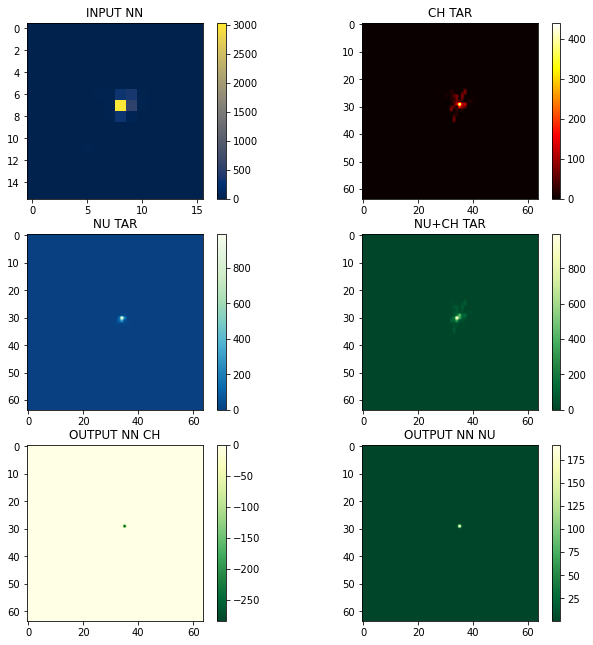

In [20]:
ev, l = 23, 1
plt.figure(figsize=(11, 11))

plt.subplot(321)
plt.title("INPUT NN")
plt.imshow(val_Layer[ev:ev+1][0][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(322)
plt.title("CH TAR")
plt.imshow(val_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(323)
plt.title("NU TAR")
plt.imshow(val_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(324)
plt.title("NU+CH TAR")
plt.imshow(val_nu[ev][l].T+val_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.subplot(325)
plt.title("OUTPUT NN CH")
plt.imshow(test_out[0][l].detach().numpy().T, cmap="YlGn_r")
plt.colorbar()

plt.subplot(326)
plt.title("OUTPUT NN NU")
plt.imshow(test_out[0][l+2].detach().numpy().T, cmap="YlGn_r")
plt.colorbar()



plt.show()

In [21]:
#train_dataset = TensorDataset( Tensor( torch.from_numpy(train_Layer).float() ),
#                               Tensor( torch.from_numpy(  train_ch ).float() ),
#                               Tensor( torch.from_numpy(  train_nu ).float() )  )
#valid_dataset = TensorDataset( Tensor( torch.from_numpy(  val_Layer).float() ),
#                               Tensor( torch.from_numpy( val_ch    ).float() ),
#                               Tensor( torch.from_numpy( val_nu    ).float() )  )

train_dataset = TensorDataset( Tensor( torch.from_numpy(train_Layer).float() ),
                               Tensor( torch.from_numpy(  train_ch+train_nu ).float() ),
                               Tensor( torch.from_numpy(  train_nu ).float() )  )
valid_dataset = TensorDataset( Tensor( torch.from_numpy(  val_Layer).float() ),
                               Tensor( torch.from_numpy( val_ch+val_nu    ).float() ),
                               Tensor( torch.from_numpy( val_nu    ).float() )  )

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20)


In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
total_step = len(train_loader)
print(total_step)

400


In [25]:
###--- ###---- LOSS FUNCTION OF CNN ----###
###--- def LossFunction(pred,tar_ch ,tar_nu ) : 
###---     pred_ch=pred[:,0:2,:,:]
###---     pred_nu=pred[:,2:4,:,:]
###---     
###---     wt_nu=torch.sum( ( tar_nu.cuda() - pred_nu.cuda() )*( tar_nu.cuda() - pred_nu.cuda() ) )
###---     wt_nu/=torch.sum(tar_nu.cuda())
###---     wt_ch=torch.sum( ( tar_ch.cuda() - pred_ch.cuda() )*( tar_ch.cuda() - pred_ch.cuda() ) )
###---     wt_ch/=torch.sum(tar_ch.cuda())
###--- 
###---     
###---     
###---     
###---     #wt_nu = torch.sum(  tar_nu.cuda() * ( tar_nu.cuda() - pred_nu.cuda() )*( tar_nu.cuda() - pred_nu.cuda() ) )
###---     #wt_nu = wt_nu / torch.sum( tar_nu.cuda()) 
###---     #
###---     #wt_ch = torch.sum(  tar_ch.cuda() * ( tar_ch.cuda() - pred_ch.cuda() )*( tar_ch.cuda() - pred_ch.cuda() ))
###---     #wt_ch = wt_ch / torch.sum( tar_ch.cuda()) 
###---     
###---     #wt_tot = torch.sum(  (tar_ch.cuda() + tar_nu.cuda()) * ( tar_ch.cuda()+ tar_nu.cuda()  - pred_ch.cuda() -pred_nu.cuda() )*( tar_ch.cuda()+ tar_nu.cuda()  - pred_ch.cuda() -pred_nu.cuda() ) )
###---     #wt_tot = wt_tot / torch.sum( (tar_ch.cuda() + tar_nu.cuda())) 
###--- 
###---     return wt_nu+wt_ch#+wt_tot

In [26]:
###---- LOSS FUNCTION OF CNN ----###
def LossFunction(pred,tar_tot ,tar_nu ) : 
    pred_tot=pred[:,0:2,:,:]
    pred_nu=pred[:,2:4,:,:]
    
    wt_nu=torch.sum( ( tar_nu.cuda() - pred_nu.cuda() )*( tar_nu.cuda() - pred_nu.cuda() ) )
    wt_nu/=torch.sum(tar_nu.cuda())
    wt_tot=torch.sum( ( tar_tot.cuda() - pred_tot.cuda() )*( tar_tot.cuda() - pred_tot.cuda() ) )
    wt_tot/=torch.sum(tar_tot.cuda())

    
    return wt_nu+wt_tot

In [27]:
train_loss_v, valid_loss_v = [], []

valid_loss_min = np.Inf # track change in validation loss

In [28]:
if( len(valid_loss_v) > 0 ) : 
    valid_loss_min = np.min( np.array(valid_loss_v) )

In [29]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    model.train() ## --- set the model to train mode -- ##
    for in_data, target_tot, target_nu in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            #print(target.shape)
            
            in_data, target_tot, target_nu = in_data.cuda(), target_tot.cuda(), target_nu.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(in_data)
        # calculate the batch loss
        loss = LossFunction(output, target_tot, target_nu)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()#*data.size(0)
    
    ######################    
    # validate the model #
    ######################

    model.eval()
    for in_data, target_tot, target_nu in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            in_data, target_tot, target_nu = in_data.cuda(), target_tot.cuda(), target_nu.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(in_data)
        # calculate the batch loss
        loss = LossFunction(output, target_tot, target_nu)
        # update average validation loss 
        valid_loss += loss.item()#*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    train_loss_v.append(train_loss) 
    valid_loss_v.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), PATH_NN)
        valid_loss_min = valid_loss

print("... End Training!")

Epoch: 1 	Training Loss: 61.257111 	Validation Loss: 58.131122
Validation loss decreased (inf --> 58.131122).  Saving model ...
Epoch: 2 	Training Loss: 54.770898 	Validation Loss: 52.776330
Validation loss decreased (58.131122 --> 52.776330).  Saving model ...
Epoch: 3 	Training Loss: 50.118156 	Validation Loss: 48.880932
Validation loss decreased (52.776330 --> 48.880932).  Saving model ...
Epoch: 4 	Training Loss: 46.701150 	Validation Loss: 45.994348
Validation loss decreased (48.880932 --> 45.994348).  Saving model ...
Epoch: 5 	Training Loss: 44.152134 	Validation Loss: 43.826870
Validation loss decreased (45.994348 --> 43.826870).  Saving model ...
Epoch: 6 	Training Loss: 42.227405 	Validation Loss: 42.180671
Validation loss decreased (43.826870 --> 42.180671).  Saving model ...
Epoch: 7 	Training Loss: 40.756718 	Validation Loss: 40.915371
Validation loss decreased (42.180671 --> 40.915371).  Saving model ...
Epoch: 8 	Training Loss: 39.618711 	Validation Loss: 39.931085
Valid

In [26]:
print(test_out.shape)

torch.Size([1, 4, 64, 64])


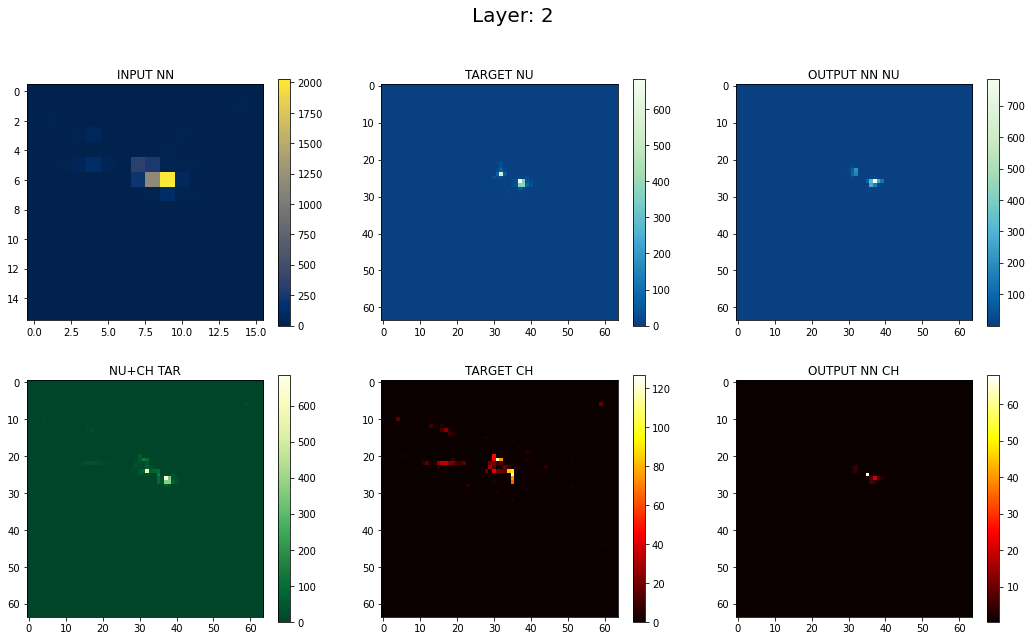

In [31]:

ev, l = 20, 1

test_out = model(  Tensor(val_Layer[ev:ev+1]).cuda() )


plt.figure(figsize=(18, 10))

plt.suptitle('Layer: '+str(l+1), fontsize=20)


plt.subplot(231)
plt.title("INPUT NN")
plt.imshow(val_Layer[ev:ev+1][0][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(234)
plt.title("NU+CH TAR")
plt.imshow(val_nu[ev][l].T+val_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.subplot(232)
plt.title("TARGET NU")
plt.imshow(val_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(235)
plt.title("TARGET CH")
plt.imshow(val_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(233)
plt.title("OUTPUT NN NU")
plt.imshow(test_out[0][l+2].detach().numpy().T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(236)
plt.title("OUTPUT NN CH")
plt.imshow(test_out[0][l].detach().numpy().T, cmap="hot")
plt.colorbar()



#plt.show()
#plt.subplot(321)
##plt.imshow(input_Layer[22:23][0][1][:16,:16])
#plt.imshow(test_out[0][0].detach().numpy())
#plt.colorbar()
#
#plt.subplot(322)
#plt.imshow(test_out[0][1].detach().numpy())
#plt.colorbar()
#
#plt.subplot(323)
#plt.imshow(test_out[0][2].detach().numpy())
#plt.colorbar()
#
#plt.subplot(324)
#plt.imshow(test_out[0][3].detach().numpy())
#plt.colorbar()
#
#plt.subplot(325)
#plt.imshow(val_Layer[29:30][0][0][:,:])
#plt.colorbar()
#
#plt.subplot(326)
#plt.imshow(val_Layer[29:30][0][1][:16,:16])
#plt.colorbar()